## Load celebA dataset

In [22]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer
from explainers_lib.model import Model as ExplainerModel
from explainers_lib.datasets import Dataset

In [2]:
# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2


In [3]:
root = r"C:\Users\user\.cache\kagglehub\datasets\jessicali9530\celeba-dataset\versions\2"
img_dir = root + "/img_align_celeba/img_align_celeba"
attr_path = os.path.join(root, "list_attr_celeba.csv")


df = pd.read_csv(attr_path)
df = df.rename(columns=lambda s: s.strip())

# Convert to numeric labels
df["Young"] = df["Young"].apply(lambda x: 1 if x == 1 else 0)
df["Smiling"] = df["Smiling"].apply(lambda x: 1 if x == 1 else 0)

df["class"] = (
    df["Young"] * 2 + df["Smiling"]
)  # creates 0–3 target class

# Keep only first 11k (10k train + 1k test)
df = df.iloc[:11000]

train_df, test_df = train_test_split(df, test_size=1000, shuffle=True, random_state=42)


transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

class Celeb4ClassDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row["image_id"])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(row["class"], dtype=torch.long)
        return img, label

train_ds = Celeb4ClassDataset(train_df, img_dir, transform)
test_ds = Celeb4ClassDataset(test_df, img_dir, transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)


## Black-box model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)   # now feature map is 8x8
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)  # 4 classes
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [5]:
cnn_model_path = 'models/torch_cnn_celeba.pth'
if not os.path.exists('models'):
    os.makedirs('models')

cnn = CNN().to(device)

if os.path.exists(cnn_model_path):
    cnn.load_state_dict(torch.load(cnn_model_path, map_location=device))
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        cnn.train()
        running_loss = 0.0
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = cnn(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

        avg_loss = running_loss / len(train_dl.dataset)
        print(f'Epoch {epoch+1}, CNN Loss: {avg_loss:.4f}')

    torch.save(cnn.state_dict(), cnn_model_path)
    print(f"Model saved to {cnn_model_path}")


### Train Autoencoder

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),   # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),# 16 -> 8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256*8*8, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)


class Decoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim

        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256*8*8),
            nn.ReLU()
        )

        self.decoder_conv = nn.Sequential(
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), # 8 -> 16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),    # 64 -> 128
            nn.Tanh()
        )

    def forward(self, x):
        x = self.decoder_fc(x)
        x = self.decoder_conv(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, latent_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [7]:
ae_model_path = 'models/torch_ae_celeba.pth'
if not os.path.exists('models'):
    os.makedirs('models')

latent_dim = 16
autoencoder = Autoencoder(latent_dim=latent_dim).to(device)

if os.path.exists(ae_model_path):
    autoencoder.load_state_dict(torch.load(ae_model_path, map_location=device))
else:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    num_epochs = 10

    for epoch in range(num_epochs):
        autoencoder.train()
        running_loss = 0.0

        for images, _ in train_dl:
            images = images.to(device)
            optimizer.zero_grad()
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(train_dl.dataset)
        print(f'Epoch {epoch+1}, AE Loss: {avg_loss:.6f}')

    torch.save(autoencoder.state_dict(), ae_model_path)
    print(f"Autoencoder saved to {ae_model_path}")

autoencoder.eval()

Autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Flatten(start_dim=1, end_dim=-1)
      (9): Linear(in_features=16384, out_features=512, bias=True)
      (10): ReLU()
      (11): Linear(in_features=512, out_features=16, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder_fc): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=16384, bias=True)
      (3): ReLU()
    )
    (decoder_conv): Sequential(
      (0): Unflatten(dim=1, unflattened_size=(256, 8, 8))
      (1): ConvTranspose2d(256, 128, ker

## Generate cfs in latent space

In [62]:
class BatchedLatentWrapper(ExplainerModel):
    def __init__(self, decoder, cnn, device):
        self.decoder = decoder
        self.cnn = cnn
        self.device = device

    def predict(self, data: Dataset) -> np.ndarray:
        latent_tensors = torch.tensor(data.data, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            decoded_images = self.decoder(latent_tensors)
            predictions = self.cnn(decoded_images)
            predicted_classes = torch.argmax(predictions, dim=1)
            
        return predicted_classes.cpu().numpy()

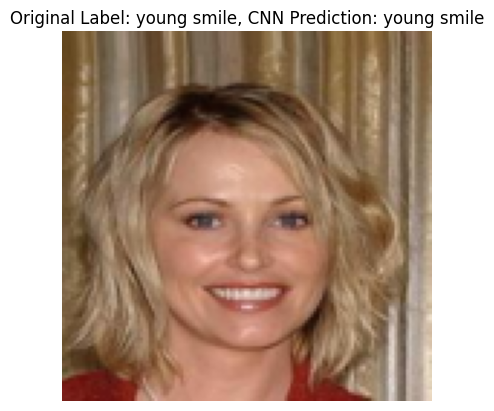

In [63]:
iter_test = iter(test_dl)
images, labels = next(iter_test)
instance_to_explain = images[0:1].to(device)
original_label = labels[0].item()

class_map = {
    0: "old no smile",
    1: "old smile",
    2: "young no smile",
    3: "young smile"
}

# Show original image
img = instance_to_explain.cpu().squeeze().permute(1, 2, 0).numpy()
img = (img * 0.5) + 0.5
plt.imshow(img)
plt.title(f'Original Label: {class_map[original_label]}, CNN Prediction: {class_map[torch.argmax(cnn(instance_to_explain), dim=1).item()]}')
plt.axis('off')
plt.show()

In [64]:
latent_instance = autoencoder.encoder(instance_to_explain)
latent_instance_np = latent_instance.cpu().detach().numpy()

feature_names = [f'l{i}' for i in range(16)]

if latent_instance_np.ndim == 1:
    data_df = pd.DataFrame(latent_instance_np.reshape(1, -1), columns=feature_names)
else:
    data_df = pd.DataFrame(latent_instance_np, columns=feature_names)

latent_dataset = Dataset(
    df=data_df,
    target=[original_label],
    features=feature_names,
    categorical_features=[],
    continuous_features=feature_names,
    immutable_features=[],
    allowable_ranges={}
)

In [69]:
latent_wrapper = BatchedLatentWrapper(autoencoder.decoder, cnn, device)
explainer = GrowingSpheresExplainer(step_size=0.1, num_samples=2, max_radius=1000.0)
counterfactuals = explainer.explain(latent_wrapper, latent_dataset)

1instance [00:00, 12.33instance/s]


In [70]:
counterfactuals

[]